### **<span style="color: #009933;">💳 Notebook Workflow At a Glance</span>**

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Notebook Overview:</u></b><br>
    
* <i> This is log data, which means each session has multiple events. For modeling, it's important to decide analysis unit.For this, please refer to basic submission demo. https://www.kaggle.com/code/philculliton/basic-submission-demo </i><br>
    
* <i> For each (session_id) _(question #), you are predicting the correct column, identifying whether you believe the user for this particular session will answer this question correctly, using only the previous information for the session.</i><br>
    
* <i> In this case, you can treat each session_id as one user. Simply speaking, I will look at all the log data of each session and predict whether user could answer each questions correctly.</i><br>
    
* <i> I assumed that user's behavior on each game level is important. Therefore, I will aggregate the data by each sessions' (users) game level. Also, I will make dummies of event_name variables so that model could learn more about each event. </i><br>
    
* <i> In sum, we build three models. 
    - learn log behavior of level group 0-4, predict questions 1-3.
    - learn log behavior of level group 5-12, predict questions 4~13
    - learn log behavior of level group 13-22, predict questions 14~18.
    </i><br>
    
* <i> In terms of modeling code, original work is done by https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664 ; Also, When ti comes to feature engineering, I modified part of this notebook. </i><br>
   
</div>

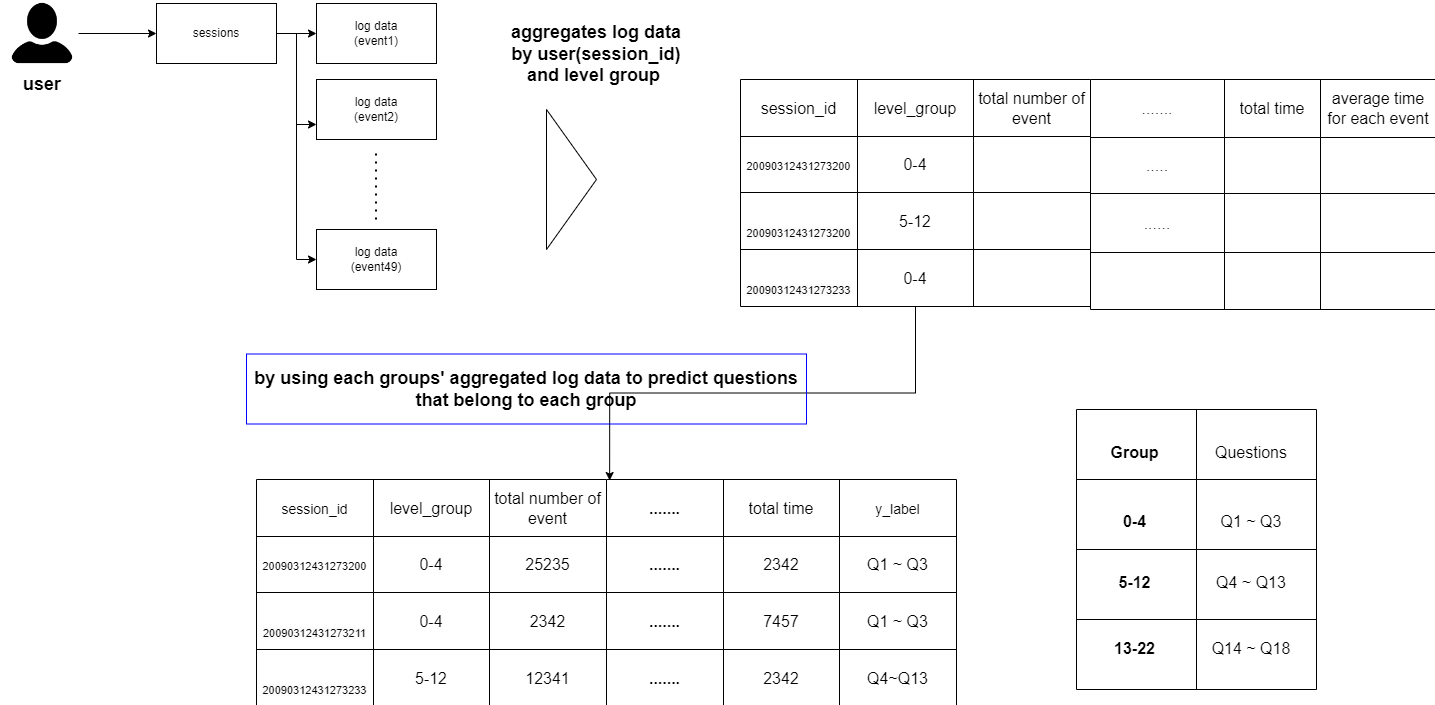

#### **<span style="color: #009933;">Exploratory Data Analysis</span>**

- session_id - the ID of the session the event took place in
- index - the index of the event for the session
- elapsed_time - how much time has passed (in milliseconds) between the start of the session and when the event was recorded
- event_name - the name of the event type
- name - the event name (e.g. identifies whether a notebook_click is is opening or closing the notebook)
- level - what level of the game the event occurred in (0 to 22)
- page - the page number of the event (only for notebook-related events)
- room_coor_x - the coordinates of the click in reference to the in-game room (only for click events)
- room_coor_y - the coordinates of the click in reference to the in-game room (only for click events)
- screen_coor_x - the coordinates of the click in reference to the player’s screen (only for click events)
- screen_coor_y - the coordinates of the click in reference to the player’s screen (only for click events)
- hover_duration - how long (in milliseconds) the hover happened for (only for hover events)
- text - the text the player sees during this event
- fqid - the fully qualified ID of the event
- room_fqid - the fully qualified ID of the room the event took place in
- text_fqid - the fully qualified ID of the
- fullscreen - whether the player is in fullscreen mode
- hq - whether the game is in high-quality
- music - whether the game music is on or off
- level_group - which group of levels - and group of questions - this row belongs to (0-4, 5-12, 13-22)

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>EDA summary:</u></b><br>
    
* <i> There are <b><u>21</u></b> columns in total - <b><u>20</u></b> X variables and <b><u>1</u></b> Y variable(correct) /1 extra variables (session_id) </i><br>
* <i> Some variables have missing data. While variables has missing data only.</i><br>
* <i> In terms of data type,there are 7 object type ,3 int type and 9 float64 type. </i><br>
* <i> There are only 3 unique session_id on test dataset. Therefore, we need to predict 3 x 18(questions) = 54 rows.</i><br>
</div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go


from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier


from matplotlib import ticker
import time
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import KFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [3]:
# Reduce Memory Usage
# reference : https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 @ARJANGROEN

def reduce_memory_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype.name
        if ((col_type != 'datetime64[ns]') & (col_type != 'category')):
            if (col_type != 'object'):
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == 'int':
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)

                else:
                    if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        pass
            else:
                df[col] = df[col].astype('category')
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage became: ",mem_usg," MB")
    
    return df

In [4]:
train_df = pd.read_csv('../../data/train.csv.gz', compression='gzip')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 20 columns):
 #   Column          Dtype  
---  ------          -----  
 0   session_id      int64  
 1   index           int64  
 2   elapsed_time    int64  
 3   event_name      object 
 4   name            object 
 5   level           int64  
 6   page            float64
 7   room_coor_x     float64
 8   room_coor_y     float64
 9   screen_coor_x   float64
 10  screen_coor_y   float64
 11  hover_duration  float64
 12  text            object 
 13  fqid            object 
 14  room_fqid       object 
 15  text_fqid       object 
 16  fullscreen      float64
 17  hq              float64
 18  music           float64
 19  level_group     object 
dtypes: float64(9), int64(4), object(7)
memory usage: 2.0+ GB


In [5]:
train_df = reduce_memory_usage(train_df)
train_df.info()

Memory usage of dataframe is 2010.23 MB
Memory usage became:  778.9939136505127  MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13174211 entries, 0 to 13174210
Data columns (total 20 columns):
 #   Column          Dtype   
---  ------          -----   
 0   session_id      int64   
 1   index           int16   
 2   elapsed_time    int32   
 3   event_name      category
 4   name            category
 5   level           int8    
 6   page            float16 
 7   room_coor_x     float16 
 8   room_coor_y     float16 
 9   screen_coor_x   float16 
 10  screen_coor_y   float16 
 11  hover_duration  float32 
 12  text            category
 13  fqid            category
 14  room_fqid       category
 15  text_fqid       category
 16  fullscreen      float64 
 17  hq              float64 
 18  music           float64 
 19  level_group     category
dtypes: category(7), float16(5), float32(1), float64(3), int16(1), int32(1), int64(1), int8(1)
memory usage: 779.0 MB


In [6]:
import gc
gc.collect()

195

In [7]:
train_label = pd.read_csv('../../data/train_labels.csv')
train_label = reduce_memory_usage(train_label)
train_label['session'] = train_label.session_id.apply(lambda x: int(x.split('_')[0]) )
train_label['q'] = train_label.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )
print( 'shape of label dataset is:',train_label.shape )

Memory usage of dataframe is 3.24 MB
Memory usage became:  10.691259384155273  MB
shape of label dataset is: (212022, 4)


In [7]:
train_label.head()

,session_id,correct,session,q
0,20090312431273200_q1,1,20090312431273200,1
1,20090312433251036_q1,0,20090312433251036,1
2,20090314121766812_q1,1,20090314121766812,1
3,20090314363702160_q1,1,20090314363702160,1
4,20090314441803444_q1,1,20090314441803444,1


In [8]:
gc.collect()

23

In [9]:
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values * 100
    summ['%missing'] = df.isnull().sum().values / len(df)
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [10]:
summary_table = summary(train_df)
summary_table

data shape: (13174211, 20)


,data type,#missing,%missing,#unique,min,max,first value,second value,third value
session_id,int64,0,0.000000,11779,20090312431273200.0,22100221145014656.0,20090312431273200,20090312431273200,20090312431273200
index,int16,0,0.000000,20348,0.0,20473.0,0,1,2
elapsed_time,int32,0,0.000000,3804019,0.0,1749293395.0,0,1323,831
event_name,category,0,0.000000,11,NaN,NaN,cutscene_click,person_click,person_click
name,category,0,0.000000,6,NaN,NaN,basic,basic,basic
level,int8,0,0.000000,23,0.0,22.0,0,0,0
page,float16,1288946500,0.978386,7,0.0,6.0,NaN,NaN,NaN
room_coor_x,float16,103624000,0.078657,28082,-1992.0,1262.0,-414.0,-414.0,-414.0
room_coor_y,float16,103624000,0.078657,25809,-918.0,543.5,-159.375,-159.375,-159.375
screen_coor_x,float16,103624000,0.078657,6266,0.0,1916.0,380.0,380.0,380.0


#### <span style="color:#339966;"> I will skip detailed EDA process.
    I assumes:
    - text matters
    - level of game matters
    - event type matters
    - elapsed time matters\
    
    Also assumes:
    - 'page', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y',
       'hover_duration', 'text_fqid', 'fullscreen', 'hq',
       'music', 'level_group'
    these data is not useful. (As there are too many missing values....)
    For coordinates variables, I am not sure how to leverage it due to lack of domain knowledge.
    
</span>

#### <span style="color:#339966;"> I will try to aggregate data by user level (session level).</span>

<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Feature engineering:</u></b><br>
    
* <i> Very smart and useful function from https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664   </i><br>
* <i> I assumed event is important factor for prediction. Therefore, I made dummies of event_name.</i><br>
* <i> I only added sum, count, mean values. You can create more variables thru EDA or domain knowledge. </i><br>
* <i> We will train with 16 features and train with 11779 users info</i><br>
</div>

In [11]:
#create dummies
just_dummies = pd.get_dummies(train_df['event_name'])

train_df = pd.concat([train_df, just_dummies], axis=1)

In [14]:
train_df.head()

,session_id,index,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,...,cutscene_click,map_click,map_hover,navigate_click,notebook_click,notification_click,object_click,object_hover,observation_click,person_click
0,20090312431273200,0,0,cutscene_click,basic,0,NaN,-414.0,-159.375,380.0,...,1,0,0,0,0,0,0,0,0,0
1,20090312431273200,1,1323,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,0,0,0,0,0,1
2,20090312431273200,2,831,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,0,0,0,0,0,1
3,20090312431273200,3,1147,person_click,basic,0,NaN,-414.0,-159.375,380.0,...,0,0,0,0,0,0,0,0,0,1
4,20090312431273200,4,1863,person_click,basic,0,NaN,-413.0,-159.375,381.0,...,0,0,0,0,0,0,0,0,0,1


In [15]:
train_df['event_name'].value_counts()

navigate_click        5687896
person_click          3024847
cutscene_click        1351732
object_click          1099670
object_hover           529116
map_hover              471621
notification_click     324106
notebook_click         284746
map_click              258714
observation_click      106260
checkpoint              35503
Name: event_name, dtype: int64

In [16]:
count_var = ['event_name', 'fqid','room_fqid', 'text']
mean_var = ['elapsed_time','level']
event_var = ['navigate_click','person_click','cutscene_click','object_click','map_hover','notification_click',
            'map_click','observation_click','checkpoint','elapsed_time']

In [17]:
# reference: https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664/notebook
def feature_engineer(train):
    dfs = []
    for c in count_var:
        tmp = train.groupby(['session_id','level_group'])[c].agg('nunique')
        tmp.name = tmp.name + '_nunique'
        dfs.append(tmp)
    for c in mean_var:
        tmp = train.groupby(['session_id','level_group'])[c].agg('mean')
        dfs.append(tmp)
    for c in event_var:
        tmp = train.groupby(['session_id','level_group'])[c].agg('sum')
        tmp.name = tmp.name + '_sum'
        dfs.append(tmp)
    df = pd.concat(dfs,axis=1)
    df = df.fillna(-1)
    df = df.reset_index()
    df = df.set_index('session_id')
    return df

In [18]:
df_tr = feature_engineer(train_df)
print( df_tr.shape )

(35337, 17)


In [22]:
df_tr.head()

,level_group,event_name_nunique,fqid_nunique,room_fqid_nunique,text_nunique,elapsed_time,level,navigate_click_sum,person_click_sum,cutscene_click_sum,object_click_sum,map_hover_sum,notification_click_sum,map_click_sum,observation_click_sum,checkpoint_sum,elapsed_time_sum
session_id,,,,,,,,,,,,,,,,,
20090312431273200,0-4,10,30,7,56,8.579356e+04,1.945455,81.0,22.0,28.0,11.0,4.0,8,2.0,4,1,1.415594e+07
20090312431273200,13-22,10,49,12,168,1.040601e+06,17.402381,170.0,123.0,60.0,20.0,14.0,10,6.0,3,1,4.370523e+08
20090312431273200,5-12,10,39,11,124,3.572052e+05,8.054054,103.0,104.0,12.0,28.0,9.0,9,8.0,1,1,1.057327e+08
20090312433251036,0-4,11,22,6,49,9.763342e+04,1.870504,49.0,18.0,36.0,15.0,3.0,5,3.0,2,1,1.357104e+07
20090312433251036,13-22,11,73,16,183,2.498852e+06,17.762529,637.0,145.0,65.0,83.0,186.0,14,45.0,5,1,3.241011e+09


In [20]:
gc.collect()

46

In [21]:
#check data type
df_tr.dtypes

level_group               category
event_name_nunique           int64
fqid_nunique                 int64
room_fqid_nunique            int64
text_nunique                 int64
elapsed_time               float64
level                      float64
navigate_click_sum         float64
person_click_sum           float64
cutscene_click_sum         float64
object_click_sum           float64
map_hover_sum              float64
notification_click_sum       uint8
map_click_sum              float64
observation_click_sum        uint8
checkpoint_sum               uint8
elapsed_time_sum           float64
dtype: object

In [23]:
FEATURES = [c for c in df_tr.columns if c != 'level_group']
print('We will train with', len(FEATURES) ,'features')
ALL_USERS = df_tr.index.unique()
print('We will train with', len(ALL_USERS) ,'users info')

We will train with 16 features
We will train with 11779 users info


<div class="alert alert-block alert-success" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    📌 &nbsp;<b><u>Modeling:</u></b><br>
    
* <i> Very smart and useful function from https://www.kaggle.com/code/cdeotte/random-forest-baseline-0-664   </i><br>
* <i> I used LGBM classifier instead of RF from original code.</i><br>
* <i> Choose best threhold based on F1 Score, which is same with the original code. </i><br>
* <i> Do not forget that you need to transform test dataset from API.</i><br>
</div>

In [24]:
gkf = GroupKFold(n_splits=5)
oof = pd.DataFrame(data=np.zeros((len(ALL_USERS),18)), index=ALL_USERS)
models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(gkf.split(X=df_tr, groups=df_tr.index)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    
    lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'learning_rate': 0.002,
    'max_depth': 6,
    'num_iterations': 1000}
    
    
    # ITERATE THRU QUESTIONS 1 THRU 18
    for t in range(1,19):
        print(t,', ',end='')
        
        # USE THIS TRAIN DATA WITH THESE QUESTIONS
        if t<=3: grp = '0-4'
        elif t<=13: grp = '5-12'
        elif t<=22: grp = '13-22'
            
        # TRAIN DATA
        train_x = df_tr.iloc[train_index]
        train_x = train_x.loc[train_x.level_group == grp]
        train_users = train_x.index.values
        train_y = train_label.loc[train_label.q==t].set_index('session').loc[train_users]
        
        # VALID DATA
        valid_x = df_tr.iloc[test_index]
        valid_x = valid_x.loc[valid_x.level_group == grp]
        valid_users = valid_x.index.values
        valid_y = train_label.loc[train_label.q==t].set_index('session').loc[valid_users]
        
        # TRAIN MODEL
        clf =  LGBMClassifier(**lgb_params)
        clf.fit(train_x[FEATURES].astype('float32'), train_y['correct'])
        
        # SAVE MODEL, PREDICT VALID OOF
        models[f'{grp}_{t}'] = clf
        oof.loc[valid_users, t-1] = clf.predict_proba(valid_x[FEATURES].astype('float32'))[:,1]
        
    print()

#########################
### Fold 1
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 2
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 3
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 4
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 
#########################
### Fold 5
#########################
1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 


In [25]:
# PUT TRUE LABELS INTO DATAFRAME WITH 18 COLUMNS
true = oof.copy()
for k in range(18):
    # GET TRUE LABELS
    tmp = train_label.loc[train_label.q == k+1].set_index('session').loc[ALL_USERS]
    true[k] = tmp.correct.values

In [26]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in np.arange(0.4,0.81,0.01):
    print(f'{threshold:.02f}, ',end='')
    preds = (oof.values.reshape((-1))>threshold).astype('int')
    m = f1_score(true.values.reshape((-1)), preds, average='macro')   
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.50, 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.70, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.80, 

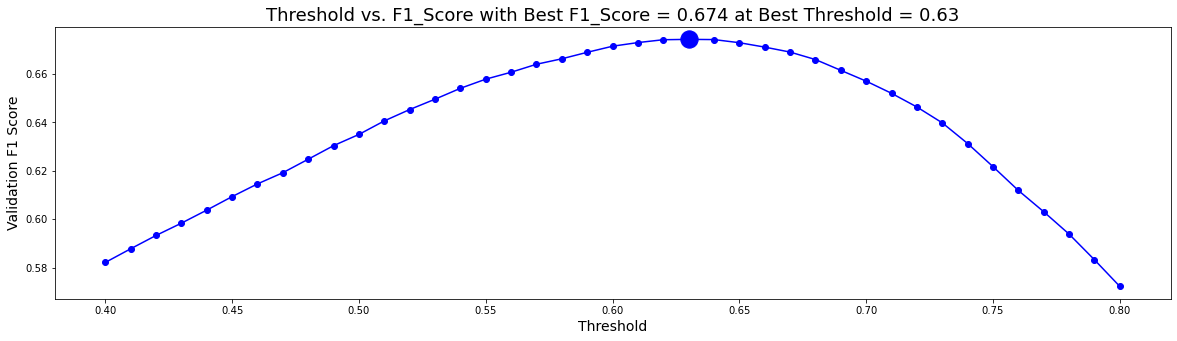

In [27]:
import matplotlib.pyplot as plt

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation F1 Score',size=14)
plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [28]:
print('When using optimal threshold...')
for k in range(18):
        
    # COMPUTE F1 SCORE PER QUESTION
    m = f1_score(true[k].values, (oof[k].values>best_threshold).astype('int'), average='macro')
    print(f'Q{k}: F1 =',m)
    
# COMPUTE F1 SCORE OVERALL
m = f1_score(true.values.reshape((-1)), (oof.values.reshape((-1))>best_threshold).astype('int'), average='macro')
print('==> Overall F1 =',m)

When using optimal threshold...
Q0: F1 = 0.5789572750475794
Q1: F1 = 0.49864232092097566
Q2: F1 = 0.4848823975979688
Q3: F1 = 0.5803516396106579
Q4: F1 = 0.54416947764779
Q5: F1 = 0.5905157777412786
Q6: F1 = 0.5843819076070677
Q7: F1 = 0.5332918554255237
Q8: F1 = 0.5901680091619177
Q9: F1 = 0.45291797320433214
Q10: F1 = 0.5884499841346579
Q11: F1 = 0.4939431735545562
Q12: F1 = 0.42338825978340106
Q13: F1 = 0.5991845747738016
Q14: F1 = 0.4463781869898538
Q15: F1 = 0.4541072048005406
Q16: F1 = 0.5244494275997651
Q17: F1 = 0.4937401234181795
==> Overall F1 = 0.6743135372138913


In [29]:
import jo_wilder
env = jo_wilder.make_env()
iter_test = env.iter_test()

In [30]:
limits = {'0-4':(1,4), '5-12':(4,14), '13-22':(14,19)}

for (sample_submission, test) in iter_test:
    
    dummies = pd.get_dummies(test['event_name'])
    test = pd.concat([test, dummies], axis=1)
    df = feature_engineer(test)
    grp = test.level_group.values[0]
    a,b = limits[grp]
    for t in range(a,b):
        clf = models[f'{grp}_{t}']
        p = clf.predict_proba(df[FEATURES].astype('float32'))[:,1]
        mask = sample_submission.session_id.str.contains(f'q{t}')
        sample_submission.loc[mask,'correct'] = int(p.item()>best_threshold)
    
    env.predict(sample_submission)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.


In [33]:
submit = pd.read_csv('submission.csv')

In [40]:
submit #my daily submission is over 5...so couldn't see the result yet;

,session_id,correct
0,20090109393214576_q1,1
1,20090109393214576_q2,1
2,20090109393214576_q3,1
3,20090312143683264_q1,1
4,20090312143683264_q2,1
5,20090312143683264_q3,1
6,20090312331414616_q1,1
7,20090312331414616_q2,1
8,20090312331414616_q3,1
9,20090109393214576_q4,1
